# Detección de Diabetes con Espectroscopia Raman utilizando técnicas de aprendizaje supervisado

In [1]:
# Se importan las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from skopt import BayesSearchCV

from BaselineRemoval import BaselineRemoval

from statistics import mode

import time
from datetime import timedelta

In [2]:
"""Se definen las funciones que se van a usar para imprimir gráficas"""

# Imprime la gráfica de un espectro Raman
def plot_df(x, y, title="", x_label=r'Desplazamiento Raman [$cm^{-1}$]', y_label='Intensidad', dpi=100, color='tab:red'):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color=color)
    plt.gca().set(title=title, xlabel=x_label, ylabel=y_label)
    plt.show()

# Imprime la gráfica de dos espectros Raman
def plot_df_compare(x, y_1, y_2, title="", x_label=r'Desplazamiento Raman [$cm^{-1}$]', y_label='Intensidad', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y_1, color='tab:red')
    plt.plot(x, y_2, color='tab:blue')
    plt.gca().set(title=title, xlabel=x_label, ylabel=y_label)
    plt.show()

# Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento
def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

# Compara losses de dos entrenamientos con nombres name1 y name2
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Losses"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1,
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()

# Compara accuracies de dos entrenamientos con nombres name1 y name2
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Accuracies"):
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1,
                'Train ' + name2, 'Val ' + name2],
               loc='lower right')
    plt.show()

# Compara accuracies de dos entrenamientos con nombres name1 y name2
def plot_compare_accs_3(history1, history2, history3, name1="Red 1",
                      name2="Red 2", name3="Red 3", title="Accuracies"):
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.plot(history3.history['accuracy'], color="red")
    plt.plot(history3.history['val_accuracy'], 'r--', color="red")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1,
                'Train ' + name2, 'Val ' + name2,
                'Train ' + name3, 'Val ' + name3],
               loc='lower right')
    plt.show()

In [3]:
# Se cargan los datos de los distintos archivos y se asignan a un Data Frame gracias a la librería pandas
RamanEarLobeDF = pd.read_csv('data/earLobe.csv')
RamanInnerArmDF = pd.read_csv('data/innerArm.csv')
RamanThumbNailDF = pd.read_csv('data/thumbNail.csv')
RamanVeinDF = pd.read_csv('data/vein.csv')

## Preprocesamiento

In [4]:
RamanInnerArmDF

,patientID,has_DM2,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var3152,Var3153,Var3154,Var3155,Var3156,Var3157,Var3158,Var3159,Var3160,Var3161
0,ramanShift,NaN,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,...,3150,3151,3152,3153,3154,3155,3156,3157,3158,3159
1,DM201,1.0,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,...,0,0,0,0,0,0,0,0,0,0
2,DM202,1.0,214.800000,214.800000,214.800000,214.800000,214.800000,214.800000,214.800000,214.800000,...,0,0,0,0,0,0,0,0,0,0
3,DM203,1.0,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,...,0,0,0,0,0,0,0,0,0,0
4,DM204,1.0,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,181.833333,...,0,0,0,0,0,0,0,0,0,0
5,DM205,1.0,179.800000,179.800000,179.800000,179.800000,179.800000,179.800000,179.800000,179.800000,...,0,0,0,0,0,0,0,0,0,0
6,DM206,1.0,237.400000,237.400000,237.400000,237.400000,237.400000,237.400000,237.400000,237.400000,...,0,0,0,0,0,0,0,0,0,0
7,DM207,1.0,217.333333,217.333333,217.333333,217.333333,217.333333,217.333333,217.333333,217.333333,...,0,0,0,0,0,0,0,0,0,0
8,DM208,1.0,89.166667,89.166667,89.166667,89.166667,89.166667,89.166667,89.166667,89.166667,...,0,0,0,0,0,0,0,0,0,0
9,DM209,1.0,336.600000,336.600000,336.600000,336.600000,336.600000,336.600000,336.600000,336.600000,...,0,0,0,0,0,0,0,0,0,0


In [5]:
"""Se definen las funciones que se usarán para el preprocesamiento de los datos"""

# Función que elimina la primera columna y se recortan los espectros a la región de 800-1800 cm^-1. Este rango fue seleccionado para que coincidiera con la región espectral de los productos finales de glicación avanzada (AGE). Posteriormente, se elimina la primera fila, que contiene los números de onda
def prepare_df (raman_df):
    raman_df = raman_df.drop(["patientID"], axis=1)
    raman_df = raman_df.drop(raman_df.iloc[:, 1:801], axis=1)
    raman_df = raman_df.drop(raman_df.iloc[:, 1002:], axis=1)
    raman_df = raman_df.drop([0])
    return raman_df

# Función imprime todos los espectros de un data frame para analizarlos
def print_raman_shift (raman_df):
    for index, paciente in raman_df.iterrows():
            plot_df(x=list(range(800, 1801)), y=paciente[1:], title=f'Paciente ' + f'DM2 {index}' if paciente["has_DM2"] == 1 else f'Ctrl {index}', color='tab:red' if paciente["has_DM2"] == 1 else 'tab:blue')

# Función que comparan dos formas de eliminar la fluorescencia, con IModPoly() y ZhangFit() de la librería BaselineRemoval, observada en los espectros Raman
def compare_remove_fluorescence_functions (raman_df):
    for index, paciente in raman_df.iterrows():
        plot_df_compare(x=list(range(800, 1801)), y_1=BaselineRemoval(paciente[1:].tolist()).IModPoly(2), y_2=BaselineRemoval(paciente[1:].tolist()).ZhangFit(), title=f'Paciente' + f'DM2 {index}' if paciente["has_DM2"] == 1 else f'Ctrl {index}')

# Función que elimina la fluorescencia con ZhangFit()
def remove_fluorescence (raman_df):
    raman_df_transform = raman_df.copy()
    for index, paciente in raman_df_transform.iterrows():
        raman_df_transform.iloc[index-1,1:] = BaselineRemoval(paciente[1:].tolist()).ZhangFit()
    return raman_df_transform

# Función que calcula la media de los espectros Raman agrupados pacientes con DM2 y Ctrl para compararlos en una gráfica
def compare_means_raman (raman_df):
    raman_df_dm2_mean = raman_df.loc[raman_df['has_DM2'] == 1].iloc[:,1:].mean()
    raman_df_ctrl_mean = raman_df.loc[raman_df['has_DM2'] == 0].iloc[:,1:].mean()
    plot_df_compare(x=list(range(800, 1801)), y_1=raman_df_dm2_mean, y_2=raman_df_ctrl_mean, title='Media DM2 vs Ctrl')

# Función que estandariza los datos restando la media y dividiendo por la desviación estándar con StandardScaler()
def standardize (raman_df):
    scaler = StandardScaler()
    raman_df.iloc[:,1:] = scaler.fit_transform(raman_df.iloc[:,1:])
    return raman_df

# Función que aplica PCA y muestra un una gráfica el acumulado de varianza explicada en las nuevas dimensiones
def apply_pca (raman_df):
    pca=PCA(.95)
    pca.fit(raman_df.iloc[:,1:])
    raman_df_pca = pca.transform(raman_df.iloc[:,1:])
    n_pca = raman_df_pca.shape[1]
    print("Dimensiones de X_pca", raman_df_pca.shape)
    print(pca.explained_variance_ratio_)
    print('Varianza explicada con 5 componentes:',sum(pca.explained_variance_ratio_[0:5]))

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Número de componentes')
    plt.ylabel('Varianza explicada acumulada')
    plt.show()

    # Se crea el data frame con el número componentes principales obtenidas
    index_pca = []
    for i in range(n_pca):
        index_pca.append(f'PC{i+1}')

    raman_df_pca = pd.DataFrame(raman_df_pca, columns=index_pca)
    # Para el correcto funcionamiento, se cambia el inicio del index a 1
    raman_df_pca.index += 1
    #S e inserta el target
    raman_df_pca.insert(loc = 0,
              column = 'has_DM2',
              value = raman_df['has_DM2'].loc[1:])
    return raman_df_pca

# Función que divide el data frame en conjuntos de train 80% y test 20%
def raman_train_test_split(raman_df):
    return train_test_split(raman_df.iloc[:,1:], raman_df['has_DM2'], test_size=0.1)

# Función que realiza todas las funciones de preprocesamiento
def df_preprocessing (raman_df):
    raman_df = prepare_df(raman_df)
    raman_df = remove_fluorescence(raman_df)
    raman_df = standardize(raman_df)
    return raman_df

# Función que realiza todas las funciones de preprocesamiento además de aplicar PCA
def df_preprocessing_pca (raman_df):
    raman_df = prepare_df(raman_df)
    raman_df = remove_fluorescence(raman_df)
    raman_df = standardize(raman_df)
    raman_df = apply_pca(raman_df)
    return raman_df

In [6]:
""" Se definen las funciones para calcular y visualizar las métricas"""

# Función que calcula las métricas utilizando sklearn
def get_metrics(y_test, y_pred):

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'conf_matrix' : conf_matrix, 'accuracy' : accuracy, 'precision' : precision, 'recall' : recall, 'f1' : f1}

# Función que calcula las métricas al final de las iteraciones
def get_final_metrics(iter_metrics):
    conf_matrix = sum(metrics_i['conf_matrix'] for metrics_i in iter_metrics)
    accuracy = float(sum(metrics_i['accuracy'] for metrics_i in iter_metrics)) / len(iter_metrics)
    precision = float(sum(metrics_i['precision'] for metrics_i in iter_metrics)) / len(iter_metrics)
    recall = float(sum(metrics_i['recall'] for metrics_i in iter_metrics)) / len(iter_metrics)
    f1 = float(sum(metrics_i['f1'] for metrics_i in iter_metrics)) / len(iter_metrics)
    return {'conf_matrix' : conf_matrix, 'accuracy' : accuracy, 'precision' : precision, 'recall' : recall, 'f1' : f1}

# Función que pinta la matriz de confusión y métricas
def plot_metrics(metrics, title):

    #Código de matplotlib para graficar
    plt.figure(figsize=(3, 3))
    matrix = pd.DataFrame(metrics['conf_matrix'],
                          columns=["0 : Ctrl", "1 : DM2"])
    plt.matshow(matrix, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Predichas")
    plt.ylabel("Reales")
    plt.xticks(range(len(matrix.columns)), matrix.columns, rotation=45)
    plt.yticks(range(len(matrix.columns)), matrix.columns)
    labels = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    for i in range(len(matrix.columns)):
        for j in range(len(matrix.columns)):
            plt.text(i, j + 0.14, str(matrix.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, labels[i][j],
                     fontsize=11.5, ha="center", va="center")
    plt.text(1.60, -0.30, title, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % metrics['accuracy'], fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % metrics['precision'], fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % metrics['recall'], fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % metrics['f1'], fontsize=20)
    plt.show()

In [7]:
# Función que realiza 1000 entrenamientos para obtener las métricas
def iter_model (raman_df, model, title):
    start_time = time.time()
    # Métricas por iteración
    iter_metrics = []

    iter_no = 1
    for i in range(1000):
        x_train, x_test, y_train, y_test = raman_train_test_split(raman_df)

        # Se entrena el modelo
        model.fit(x_train, y_train)

        # Se obtiene la predicción y las métricas
        y_pred = model.predict(x_test)
        metric = get_metrics(y_test, y_pred.round())
        iter_metrics.append(metric)

        iter_no = iter_no + 1

    # Se pintan la media de las métricas y la matriz de confusión
    final_metrics = get_final_metrics(iter_metrics)
    print('------------------------------------------------------------------------')
    print(f'Tiempo transcurrido (iter_model_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    plot_metrics(final_metrics, title)
    return final_metrics

In [8]:
RamanEarLobeDF_preprocessed = df_preprocessing(RamanEarLobeDF)
RamanInnerArmDF_preprocessed = df_preprocessing(RamanInnerArmDF)
RamanThumbNailDF_preprocessed = df_preprocessing(RamanThumbNailDF)
RamanVeinDF_preprocessed = df_preprocessing(RamanVeinDF)
RamanDF_preprocessed = {'EarLobe' : RamanEarLobeDF_preprocessed,
                        'InnerArm' : RamanInnerArmDF_preprocessed,
                        'ThumbNail' : RamanThumbNailDF_preprocessed,
                        'Vein' : RamanVeinDF_preprocessed}

Dimensiones de X_pca (20, 12)
[0.58652943 0.15351859 0.06862393 0.03510903 0.02383198 0.01738268
 0.01552876 0.01431898 0.01299144 0.01133923 0.0102168  0.00891572]
Varianza explicada con 5 componentes: 0.8676129600227221


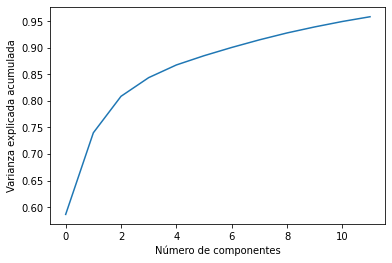

Dimensiones de X_pca (20, 12)
[0.64469483 0.11374171 0.05166191 0.03316092 0.02153084 0.01568177
 0.01330198 0.01239332 0.0118334  0.01117849 0.01093558 0.01003453]
Varianza explicada con 5 componentes: 0.8647902032371606


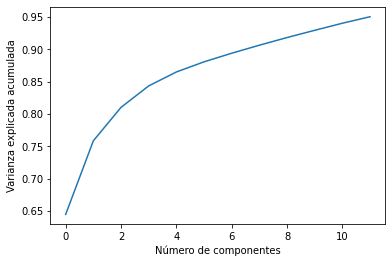

Dimensiones de X_pca (20, 11)
[0.6677955  0.09513463 0.06292486 0.04086866 0.02908171 0.01630976
 0.01110785 0.01000491 0.00868286 0.00786968 0.00756529]
Varianza explicada con 5 componentes: 0.8958053649254455


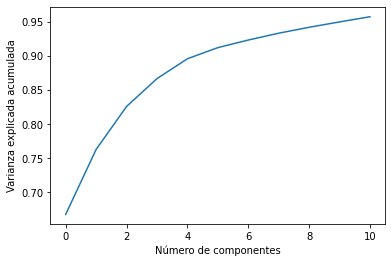

Dimensiones de X_pca (20, 14)
[0.54342802 0.14903546 0.07064525 0.03598282 0.02956338 0.01923196
 0.0170476  0.01609422 0.01583872 0.01500818 0.01345601 0.01251607
 0.01207391 0.01064604]
Varianza explicada con 5 componentes: 0.8286549235562187


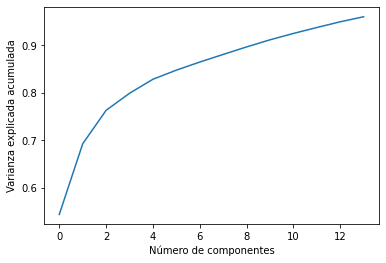

In [9]:
RamanEarLobeDF_preprocessed_pca = df_preprocessing_pca(RamanEarLobeDF)
RamanInnerArmDF_preprocessed_pca = df_preprocessing_pca(RamanInnerArmDF)
RamanThumbNailDF_preprocessed_pca = df_preprocessing_pca(RamanThumbNailDF)
RamanVeinDF_preprocessed_pca = df_preprocessing_pca(RamanVeinDF)
RamanDF_preprocessed_pca = {'EarLobe' : RamanEarLobeDF_preprocessed_pca,
                            'InnerArm' : RamanInnerArmDF_preprocessed_pca,
                            'ThumbNail' : RamanThumbNailDF_preprocessed_pca,
                            'Vein' : RamanVeinDF_preprocessed_pca}

In [10]:
RamanInnerArmDF.drop([0]).describe()

,has_DM2,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var3152,Var3153,Var3154,Var3155,Var3156,Var3157,Var3158,Var3159,Var3160,Var3161
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,0.550000,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,220.231667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.510418,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,105.314436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,71.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,146.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.000000,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,216.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,321.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,457.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### RNA

In [11]:
# Modelo para buscar la los hiperparámetros óptimos, requerido por KerasClassifier
def create_model(learning_rate=0.01, momentum=0, kernel_initializer='glorot_uniform', activation='sigmoid'):
    model = keras.Sequential()
    model.add(layers.Dense(14, kernel_initializer=kernel_initializer, activation=activation))
    model.add(layers.Dense(1, kernel_initializer=kernel_initializer, activation='sigmoid'))

    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [12]:
"""Se crean las funciones que realizan búsquedas en rejilla para obtener los hiperparámetros óptimos"""
def best_epochs_bach_size (x_train, y_train):
    start_time = time.time()
    model = KerasClassifier(build_fn=create_model, verbose=0)
    # Se define la rejilla con los hiperparámetros
    batch_size = [2, 5, 10]
    epochs = [50, 100, 500]
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=LeaveOneOut())
    grid_result = grid.fit(x_train, y_train)

    # Resultados
    print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    best_epochs = grid_result.best_params_['epochs']
    best_batch = grid_result.best_params_['batch_size']
    print(f'Tiempo transcurrido: {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return best_epochs, best_batch

def best_learning_rate_momentum (x_train, y_train, epochs, batch_size):
    start_time = time.time()
    model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
    # Se define la rejilla con los hiperparámetros
    learning_rate = [0.001, 0.01, 0.1]
    momentum = [0.4, 0.6, 0.8, 0.9]
    param_grid = dict(learning_rate=learning_rate, momentum=momentum)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=LeaveOneOut())
    grid_result = grid.fit(x_train, y_train)

    # Resultados
    print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    best_learning_rate = grid_result.best_params_['learning_rate']
    best_momentum = grid_result.best_params_['momentum']
    print(f'Tiempo transcurrido: {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return best_learning_rate, best_momentum

def best_kernel_initializer (x_train, y_train, epochs, batch_size, learning_rate, momentum):
    start_time = time.time()
    model = KerasClassifier(build_fn=create_model, learning_rate=learning_rate, momentum=momentum, epochs=epochs, batch_size=batch_size, verbose=0)
    # Se define la rejilla con los hiperparámetros
    kernel_initializer = ['uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    param_grid = dict(kernel_initializer=kernel_initializer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=LeaveOneOut())
    grid_result = grid.fit(x_train, y_train)

    # Resultados
    print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    best_kernel_init = grid_result.best_params_['kernel_initializer']
    print(f'Tiempo transcurrido: {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return best_kernel_init

def best_activation (x_train, y_train, epochs, batch_size, learning_rate, momentum, kernel_initializer):
    start_time = time.time()
    model = KerasClassifier(build_fn=create_model, learning_rate=learning_rate, momentum=momentum, kernel_initializer=kernel_initializer, epochs=epochs, batch_size=batch_size, verbose=0)
    # Se define la rejilla con los hiperparámetros
    activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    param_grid = dict(activation=activation)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=LeaveOneOut())
    grid_result = grid.fit(x_train, y_train)

    # Resultados
    print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    best_activ = grid_result.best_params_['activation']
    print(f'Tiempo transcurrido: {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return best_activ

# Se engloban todas las funciones que obtienen los hiperparámetros
def best_hyperparameters_rna (x, y):
    start_time = time.time()
    best_epochs, best_batch = best_epochs_bach_size(x, y)
    best_learning_rate, best_momentum = best_learning_rate_momentum(x, y, best_epochs, best_batch)
    best_kernel_init = best_kernel_initializer(x, y, best_epochs, best_batch, best_learning_rate, best_momentum)
    best_activ = best_activation(x, y, best_epochs, best_batch, best_learning_rate, best_momentum, best_kernel_init)
    print(f'Tiempo transcurrido (best_hyperparameters_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_epochs' : best_epochs,
            'best_batch' : best_batch,
            'best_learning_rate' : best_learning_rate,
            'best_momentum' : best_momentum,
            'best_kernel_init' : best_kernel_init,
            'best_activ' : best_activ}

In [13]:
# Se crea la función que obtiene los mejores hiperparámetros en 10 iteraciones
def hyperparameters_model_rna (raman_df):
    start_time = time.time()
    # Hiperparámetros por iteración
    iter_hyperparameters = []

    for i in range(10):
        iter_hyperparameters.append(best_hyperparameters_rna(raman_df.iloc[:,1:], raman_df['has_DM2']))

    epochs = []
    batch = []
    learning_rate = []
    momentum = []
    kernel_init = []
    activ = []

    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros por iteración')
    for index, hyperparameters_i in enumerate(iter_hyperparameters):
        print('------------------------------------------------------------------------')
        print(f"> Iteración {index + 1} - hiperparámetros: {hyperparameters_i}")
        epochs.append(hyperparameters_i['best_epochs'])
        batch.append(hyperparameters_i['best_batch'])
        learning_rate.append(hyperparameters_i['best_learning_rate'])
        momentum.append(hyperparameters_i['best_momentum'])
        kernel_init.append(hyperparameters_i['best_kernel_init'])
        activ.append(hyperparameters_i['best_activ'])
    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros finales')
    print(f'best_epochs: {mode(epochs)}, best_batch : {mode(batch)}, best_learning_rate: {mode(learning_rate)}, best_momentum: {mode(momentum)}, best_kernel_init: {mode(kernel_init)}, best_activ: {mode(activ)}')
    print(f'Tiempo transcurrido (hyperparameters_model_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_epochs' : mode(epochs),
            'best_batch' : mode(batch),
            'best_learning_rate' : mode(learning_rate),
            'best_momentum' : mode(momentum),
            'best_kernel_init' : mode(kernel_init),
            'best_activ' : mode(activ)}

In [14]:
# Función que realiza 1000 entrenamientos para obtener las métricas
def iter_model_rna (raman_df, hyperparams, title):
    start_time = time.time()
    # Métricas por iteración
    iter_metrics = []

    iter_no = 1
    for i in range(1000):
        x_train, x_test, y_train, y_test = raman_train_test_split(raman_df)

        # Se crea el modelo
        model_rna = create_model(hyperparams['best_learning_rate'], hyperparams['best_momentum'], hyperparams['best_kernel_init'], hyperparams['best_activ'])
        model_rna.fit(x_train, y_train, epochs=hyperparams['best_epochs'], batch_size=hyperparams['best_batch'], verbose=0)

        # Se obtiene la predicción y las métricas
        y_pred = model_rna.predict(x_test)
        metric = get_metrics(y_test, y_pred.round())
        iter_metrics.append(metric)

        iter_no = iter_no + 1

    # Se pintan la media de las métricas y la matriz de confusión
    final_metrics = get_final_metrics(iter_metrics)
    print('------------------------------------------------------------------------')
    print(f'Tiempo transcurrido (iter_model_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    plot_metrics(final_metrics, title)
    return final_metrics

In [15]:
start_time_rna = time.time()
hyperparameters_rna = hyperparameters_model_rna(RamanInnerArmDF_preprocessed)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_rna))}')

Best accuracy: 0.650000 using {'batch_size': 2, 'epochs': 50}
Tiempo transcurrido: 0:04:28.124584
------------------------------------------------------------------------
Best accuracy: 0.650000 using {'learning_rate': 0.1, 'momentum': 0.8}
Tiempo transcurrido: 0:03:03.335111
------------------------------------------------------------------------
Best accuracy: 0.650000 using {'kernel_initializer': 'uniform'}
Tiempo transcurrido: 0:01:34.049735
------------------------------------------------------------------------
Best accuracy: 0.650000 using {'activation': 'softsign'}
Tiempo transcurrido: 0:01:46.438095
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters_rna): 0:10:51.947526
------------------------------------------------------------------------
Best accuracy: 0.700000 using {'batch_size': 5, 'epochs': 50}
Tiempo transcurrido: 0:03:04.008901
------------------------------------------------------------------------
Best

1/1 [==============================] - 0s 49ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:15:14.685186
------------------------------------------------------------------------


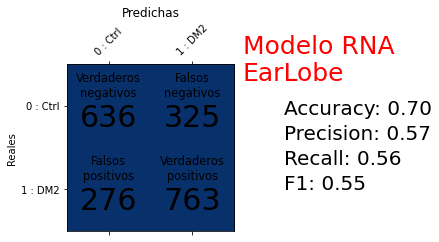

Tiempo transcurrido para las 1000 iteraciones (total): 0:15:14.988415
1/1 [==============================] - 0s 42ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:10:29.329790
------------------------------------------------------------------------


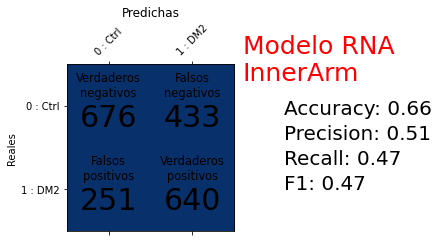

Tiempo transcurrido para las 1000 iteraciones (total): 0:10:29.515644
1/1 [==============================] - 0s 56ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:10:39.206892
------------------------------------------------------------------------


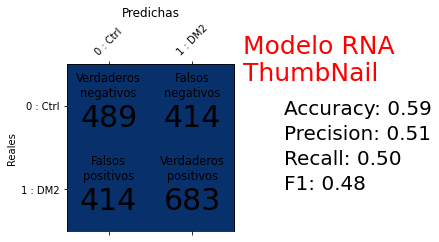

Tiempo transcurrido para las 1000 iteraciones (total): 0:10:39.381299
1/1 [==============================] - 0s 43ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:10:36.365383
------------------------------------------------------------------------


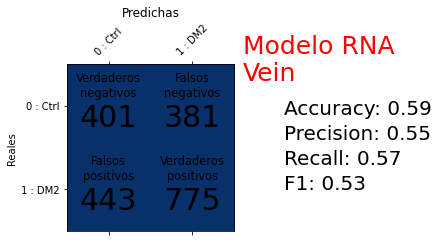

Tiempo transcurrido para las 1000 iteraciones (total): 0:10:36.567782


In [16]:
metrics_rna = {}
for raman_key, raman_value in RamanDF_preprocessed.items():
    start_time_rna = time.time()
    metrics_rna[raman_key] = iter_model_rna(raman_value, hyperparameters_rna, f'Modelo RNA\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_rna))}')

In [17]:
start_time_rna = time.time()
hyperparameters_rna_pca = hyperparameters_model_rna(RamanInnerArmDF_preprocessed_pca)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_rna))}')

Best accuracy: 0.650000 using {'batch_size': 2, 'epochs': 50}
Tiempo transcurrido: 0:03:00.567780
------------------------------------------------------------------------
Best accuracy: 0.650000 using {'learning_rate': 0.001, 'momentum': 0.8}
Tiempo transcurrido: 0:02:01.684147
------------------------------------------------------------------------
Best accuracy: 0.600000 using {'kernel_initializer': 'glorot_uniform'}
Tiempo transcurrido: 0:01:09.813259
------------------------------------------------------------------------
Best accuracy: 0.750000 using {'activation': 'tanh'}
Tiempo transcurrido: 0:01:19.517448
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters_rna): 0:07:31.582634
------------------------------------------------------------------------
Best accuracy: 0.700000 using {'batch_size': 2, 'epochs': 100}
Tiempo transcurrido: 0:02:28.138830
-----------------------------------------------------------------------

1/1 [==============================] - 0s 64ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:24:28.828739
------------------------------------------------------------------------


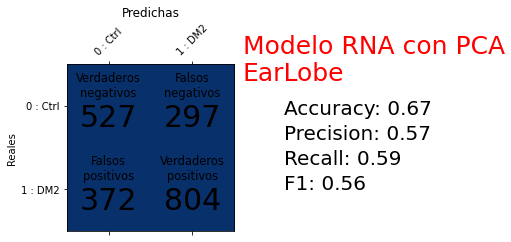

Tiempo transcurrido para las 1000 iteraciones (total): 0:24:29.117086
1/1 [==============================] - 0s 58ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:21:43.089180
------------------------------------------------------------------------


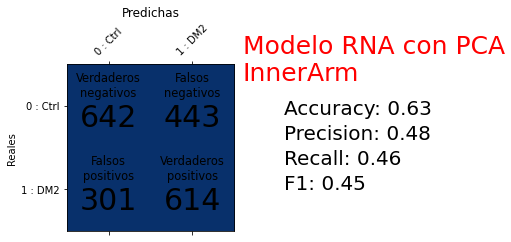

Tiempo transcurrido para las 1000 iteraciones (total): 0:21:43.313941
1/1 [==============================] - 0s 61ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:22:01.833463
------------------------------------------------------------------------


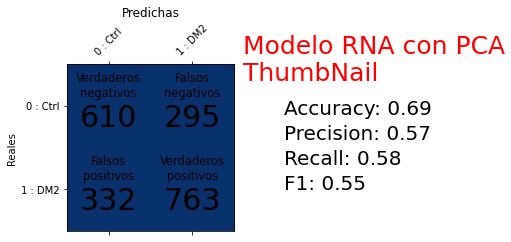

Tiempo transcurrido para las 1000 iteraciones (total): 0:22:02.014268
1/1 [==============================] - 0s 47ms/step
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:21:51.197354
------------------------------------------------------------------------


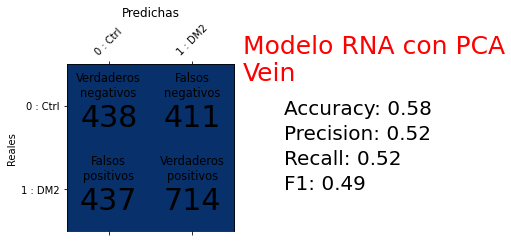

Tiempo transcurrido para las 1000 iteraciones (total): 0:21:51.382572


In [18]:
metrics_rna_pca = {}
for raman_key, raman_value in RamanDF_preprocessed_pca.items():
    start_time_rna = time.time()
    metrics_rna_pca[raman_key] = iter_model_rna(raman_value, hyperparameters_rna_pca, f'Modelo RNA con PCA\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_rna))}')

Epoch 1/50
2/2 [==============================] - 1s 246ms/step - loss: 0.6601 - accuracy: 0.6875 - val_loss: 0.7781 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6436 - accuracy: 0.6875 - val_loss: 0.7534 - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6218 - accuracy: 0.6875 - val_loss: 0.7285 - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6006 - accuracy: 0.7500 - val_loss: 0.7102 - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 0s 34ms/step - loss: 0.5852 - accuracy: 0.8125 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 6/50
2/2 [==============================] - 0s 36ms/step - loss: 0.5705 - accuracy: 0.8750 - val_loss: 0.6791 - val_accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 0s 31ms/step - loss: 0.5594 - accuracy: 0.8750 - val_loss: 0.6671 - val_accuracy: 0.5000
Epoch 8/50
2/2 [==========

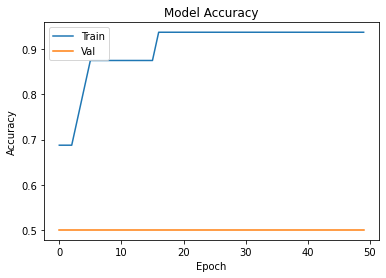

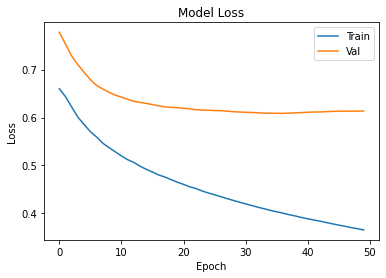

(None, None)

In [19]:
best_modelRNA = create_model(hyperparameters_rna['best_learning_rate'], hyperparameters_rna['best_momentum'], hyperparameters_rna['best_kernel_init'], hyperparameters_rna['best_activ'])
x_train_rna, x_test_rna, y_train_rna, y_test_rna = raman_train_test_split(RamanInnerArmDF_preprocessed)
historyRNA = best_modelRNA.fit(x_train_rna, y_train_rna, epochs=hyperparameters_rna['best_epochs'], batch_size=hyperparameters_rna['best_batch'], verbose=1, validation_split=0.1)
plot_acc(historyRNA), plot_loss(historyRNA)

In [20]:
best_modelRNA.summary()

Model: "sequential_8080"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16160 (Dense)         (None, 14)                14028     
                                                                 
 dense_16161 (Dense)         (None, 1)                 15        
                                                                 
Total params: 14,043
Trainable params: 14,043
Non-trainable params: 0
_________________________________________________________________


### SVM

In [21]:
# Función que busca los hiperparámetros óptimos utilizando, en este caso, BayesSearchCV()
def best_hyperparameters_svm (x, y):
    start_time = time.time()

    # Se define los hiperparámetros para la búsqueda
    params = dict()
    params['C'] = (1e-6, 100.0, 'log-uniform')
    params['gamma'] = (1e-6, 100.0, 'log-uniform')
    params['degree'] = (1,5)
    params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']

    search = BayesSearchCV(estimator=SVC(), search_spaces=params, n_jobs=-1, cv=LeaveOneOut())
    search.fit(x, y)

    # Resultados
    print("Best accuracy: %f using %s" % (search.best_score_, search.best_params_))

    best_c = search.best_params_['C']
    best_gamma = search.best_params_['gamma']
    best_degree = search.best_params_['degree']
    best_kernel = search.best_params_['kernel']
    print(f'Tiempo transcurrido (best_hyperparameters): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_c' : best_c,
            'best_gamma' : best_gamma,
            'best_degree' : best_degree,
            'best_kernel' : best_kernel}

In [22]:
# Se crea la función que obtiene los mejores hiperparámetros en 10 iteraciones
def hyperparameters_model_svm (raman_df):
    start_time = time.time()
    # Hiperparámetros por iteración
    iter_hyperparameters = []

    for i in range(10):
        iter_hyperparameters.append(best_hyperparameters_svm(raman_df.iloc[:,1:], raman_df['has_DM2']))

    c = []
    gamma = []
    degree = []
    kernel = []

    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros por iteración')
    for index, hyperparameters_i in enumerate(iter_hyperparameters):
        print('------------------------------------------------------------------------')
        print(f"> Iteración {index + 1} - hiperparámetros: {hyperparameters_i}")
        c.append(hyperparameters_i['best_c'])
        gamma.append(hyperparameters_i['best_gamma'])
        degree.append(hyperparameters_i['best_degree'])
        kernel.append(hyperparameters_i['best_kernel'])
    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros finales')
    print(f'C: {mode(c)}, gamma : {mode(gamma)}, degree: {mode(degree)}, kernel: {mode(kernel)}')
    print(f'Tiempo transcurrido (hyperparameters_model_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_c' : mode(c),
            'best_gamma' : mode(gamma),
            'best_degree' : mode(degree),
            'best_kernel' : mode(kernel)}

In [23]:
start_time_svm = time.time()
hyperparameters_svm = hyperparameters_model_svm(RamanInnerArmDF_preprocessed)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_svm))}')

Best accuracy: 0.700000 using OrderedDict([('C', 49.85934297185423), ('degree', 3), ('gamma', 0.0005163587819669441), ('kernel', 'sigmoid')])
Tiempo transcurrido (best_hyperparameters): 0:01:34.761334
------------------------------------------------------------------------
Best accuracy: 0.650000 using OrderedDict([('C', 0.06725714024586851), ('degree', 4), ('gamma', 1.3517680391945766e-05), ('kernel', 'linear')])
Tiempo transcurrido (best_hyperparameters): 0:01:18.446468
------------------------------------------------------------------------
Best accuracy: 0.650000 using OrderedDict([('C', 0.12366468587345095), ('degree', 2), ('gamma', 3.7512535732800236e-06), ('kernel', 'linear')])
Tiempo transcurrido (best_hyperparameters): 0:01:14.430632
------------------------------------------------------------------------
Best accuracy: 0.700000 using OrderedDict([('C', 16.382156481946794), ('degree', 5), ('gamma', 10.72965024482042), ('kernel', 'sigmoid')])
Tiempo transcurrido (best_hyperpara

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:20.415322
------------------------------------------------------------------------


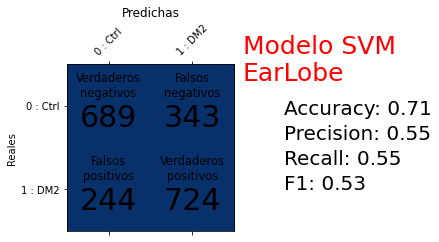

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:20.627580
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:19.700754
------------------------------------------------------------------------


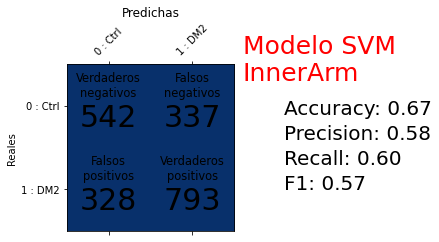

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:19.852377
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:17.256107
------------------------------------------------------------------------


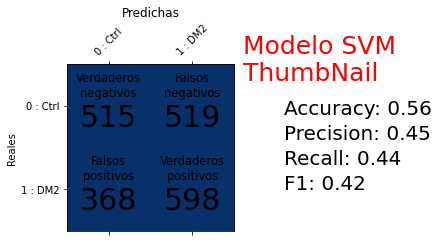

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:17.427160
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:19.405448
------------------------------------------------------------------------


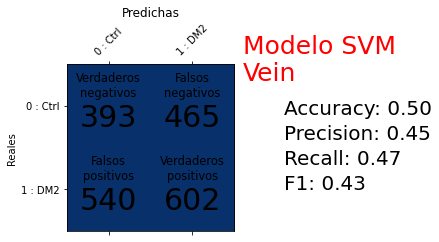

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:19.559181


In [24]:
metrics_svm = {}
for raman_key, raman_value in RamanDF_preprocessed.items():
    start_time_svm = time.time()
    modelSVM = SVC(C=hyperparameters_svm['best_c'], gamma=hyperparameters_svm['best_gamma'], degree=hyperparameters_svm['best_degree'], kernel=hyperparameters_svm['best_kernel'])
    metrics_svm[raman_key] = iter_model(raman_value, modelSVM, f'Modelo SVM\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_svm))}')

In [25]:
start_time_svm = time.time()
hyperparameters_svm_pca = hyperparameters_model_svm(RamanInnerArmDF_preprocessed_pca)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_svm))}')

Best accuracy: 0.600000 using OrderedDict([('C', 60.57564754794934), ('degree', 4), ('gamma', 0.006031977703404188), ('kernel', 'linear')])
Tiempo transcurrido (best_hyperparameters): 0:00:56.336383
------------------------------------------------------------------------
Best accuracy: 0.650000 using OrderedDict([('C', 0.028927962926355296), ('degree', 5), ('gamma', 0.001194897630451072), ('kernel', 'linear')])
Tiempo transcurrido (best_hyperparameters): 0:01:08.411028
------------------------------------------------------------------------
Best accuracy: 0.600000 using OrderedDict([('C', 0.0010495660747810946), ('degree', 3), ('gamma', 4.467321646543269e-06), ('kernel', 'linear')])
Tiempo transcurrido (best_hyperparameters): 0:01:02.665648
------------------------------------------------------------------------
Best accuracy: 0.600000 using OrderedDict([('C', 7.442002068492795), ('degree', 5), ('gamma', 4.013998085977679e-05), ('kernel', 'linear')])
Tiempo transcurrido (best_hyperpara

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:08.317602
------------------------------------------------------------------------


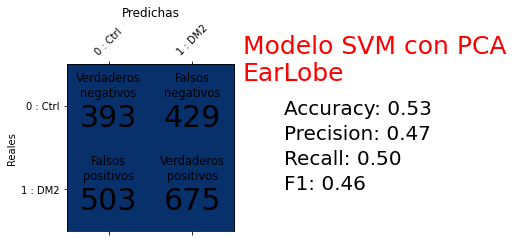

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:08.700165
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:08.726562
------------------------------------------------------------------------


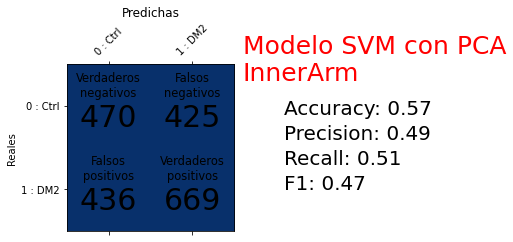

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:08.913398
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:05.730946
------------------------------------------------------------------------


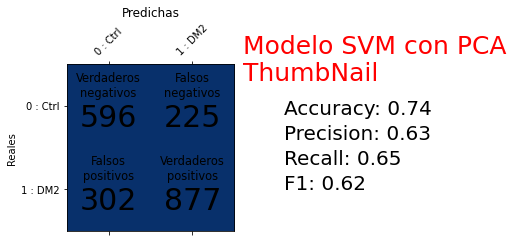

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:05.905445
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:06.041553
------------------------------------------------------------------------


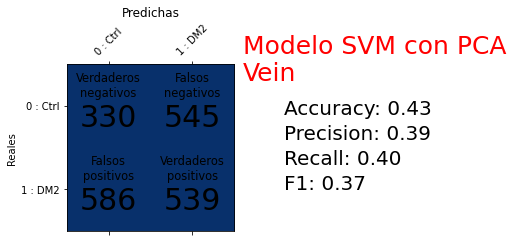

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.208969


In [26]:
metrics_svm_pca = {}
for raman_key, raman_value in RamanDF_preprocessed_pca.items():
    start_time_svm = time.time()
    modelSVM_pca = SVC(C=hyperparameters_svm_pca['best_c'], gamma=hyperparameters_svm_pca['best_gamma'], degree=hyperparameters_svm_pca['best_degree'], kernel=hyperparameters_svm_pca['best_kernel'])
    metrics_svm_pca[raman_key] = iter_model(raman_value, modelSVM_pca, f'Modelo SVM con PCA\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_svm))}')

### Random Forest

In [12]:
# Función que busca los hiperparámetros óptimos utilizando, en este caso, RandomizedSearchCV()
def best_hyperparameters_rf(x, y):
    start_time = time.time()

    # Se definen los hiperparámetros de búsqueda
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Se realiza una búsqueda aleatoria de 100 combinaciones de hiperparámetros
    rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = LeaveOneOut(), verbose=1, n_jobs = -1)
    rf_random.fit(x, y)

    best_n_estimators = rf_random.best_params_['n_estimators']
    best_max_features = rf_random.best_params_['max_features']
    best_max_depth = rf_random.best_params_['max_depth']
    best_min_samples_split = rf_random.best_params_['min_samples_split']
    best_min_samples_leaf = rf_random.best_params_['min_samples_leaf']
    best_bootstrap = rf_random.best_params_['bootstrap']
    print(f'Tiempo transcurrido (best_hyperparameters): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_n_estimators': best_n_estimators,
           'best_max_features': best_max_features,
           'best_max_depth': best_max_depth,
           'best_min_samples_split': best_min_samples_split,
           'best_min_samples_leaf': best_min_samples_leaf,
           'best_bootstrap': best_bootstrap}

In [13]:
# Se crea la función que obtiene los mejores hiperparámetros en 10 iteraciones
def hyperparameters_model_rf(raman_df):
    start_time = time.time()
    # Hiperparámetros por iteración
    iter_hyperparameters = []

    for i in range(10):
        iter_hyperparameters.append(best_hyperparameters_rf(raman_df.iloc[:, 1:], raman_df['has_DM2']))

    n_estimators = []
    max_features = []
    max_depth = []
    min_samples_split = []
    min_samples_leaf = []
    bootstrap = []

    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros por iteración')
    for index, hyperparameters_i in enumerate(iter_hyperparameters):
        print('------------------------------------------------------------------------')
        print(f"> Iteración {index + 1} - hiperparámetros: {hyperparameters_i}")
        n_estimators.append(hyperparameters_i['best_n_estimators'])
        max_features.append(hyperparameters_i['best_max_features'])
        max_depth.append(hyperparameters_i['best_max_depth'])
        min_samples_split.append(hyperparameters_i['best_min_samples_split'])
        min_samples_leaf.append(hyperparameters_i['best_min_samples_leaf'])
        bootstrap.append(hyperparameters_i['best_bootstrap'])
    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros finales')
    print(f'n_estimators: {mode(n_estimators)}, max_features : {mode(max_features)}, max_depth: {mode(max_depth)}, min_samples_split: {mode(min_samples_split)}, min_samples_leaf: {mode(min_samples_leaf)}, bootstrap: {mode(bootstrap)}')
    print(f'Tiempo transcurrido (hyperparameters_model_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_n_estimators': mode(n_estimators),
            'best_max_features': mode(max_features),
            'best_max_depth': mode(max_depth),
            'best_min_samples_split': mode(min_samples_split),
            'best_min_samples_leaf': mode(min_samples_leaf),
            'best_bootstrap': mode(bootstrap)}

In [14]:
start_time_rf = time.time()
hyperparameters_rf = hyperparameters_model_rf(RamanInnerArmDF_preprocessed)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_rf))}')

Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:17:26.020137
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:17:44.111662
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:16:09.867459
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:18:14.037134
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:16:08.119627
------------------------------------------------------------------------
Fitting 20 fold

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:31:30.853659
------------------------------------------------------------------------


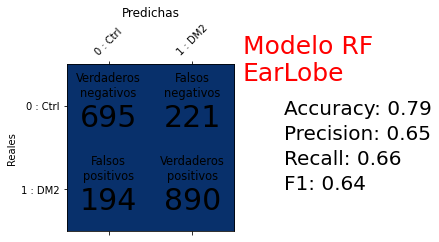

Tiempo transcurrido para las 1000 iteraciones (total): 0:31:31.132613
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:23:40.072893
------------------------------------------------------------------------


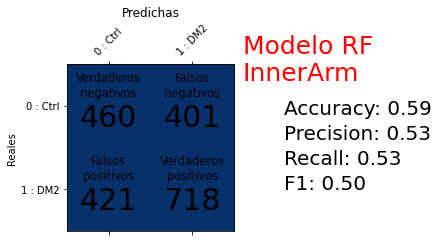

Tiempo transcurrido para las 1000 iteraciones (total): 0:23:40.270823
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:24:06.975885
------------------------------------------------------------------------


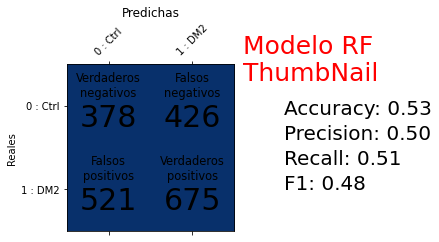

Tiempo transcurrido para las 1000 iteraciones (total): 0:24:07.135298
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:22:23.620532
------------------------------------------------------------------------


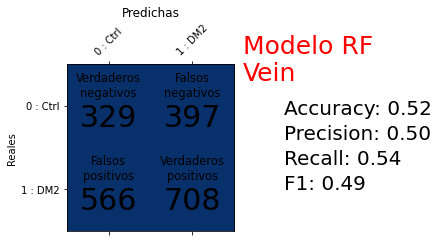

Tiempo transcurrido para las 1000 iteraciones (total): 0:22:23.774056


In [15]:
metrics_rf = {}
for raman_key, raman_value in RamanDF_preprocessed.items():
    start_time_rf = time.time()
    modelRF = RandomForestClassifier(n_estimators=hyperparameters_rf['best_n_estimators'],
                                     max_features=hyperparameters_rf['best_max_features'],
                                     max_depth=hyperparameters_rf['best_max_depth'],
                                     min_samples_split=hyperparameters_rf['best_min_samples_split'],
                                     min_samples_leaf=hyperparameters_rf['best_min_samples_leaf'],
                                     bootstrap=hyperparameters_rf['best_bootstrap'])
    metrics_rf[raman_key] = iter_model(raman_value, modelRF, f'Modelo RF\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_rf))}')

In [16]:
start_time_rf = time.time()
hyperparameters_rf_pca = hyperparameters_model_rf(RamanInnerArmDF_preprocessed_pca)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_rf))}')

Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:15:16.527089
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:16:05.200139
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:15:32.852317
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:15:25.934410
------------------------------------------------------------------------
Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Tiempo transcurrido (best_hyperparameters): 0:13:48.555658
------------------------------------------------------------------------
Fitting 20 fold

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:08:24.676894
------------------------------------------------------------------------


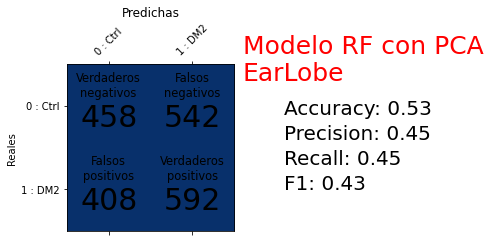

Tiempo transcurrido para las 1000 iteraciones (total): 0:08:25.061963
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:03:22.407789
------------------------------------------------------------------------


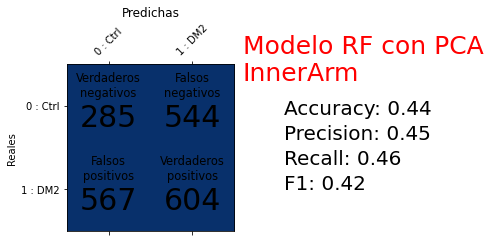

Tiempo transcurrido para las 1000 iteraciones (total): 0:03:22.579631
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:03:03.249554
------------------------------------------------------------------------


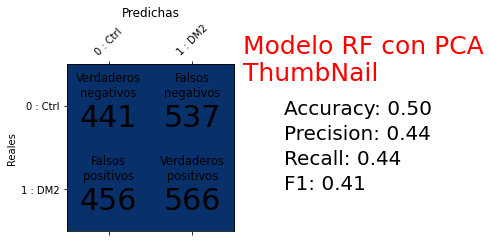

Tiempo transcurrido para las 1000 iteraciones (total): 0:03:03.427897
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:02:48.365412
------------------------------------------------------------------------


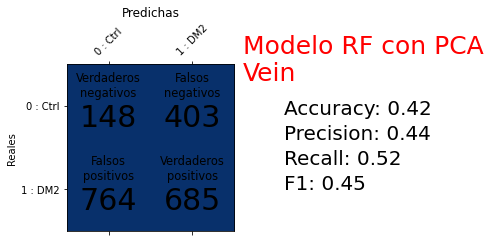

Tiempo transcurrido para las 1000 iteraciones (total): 0:02:48.534305


In [17]:
metrics_rf_pca = {}
for raman_key, raman_value in RamanDF_preprocessed_pca.items():
    start_time_rf = time.time()
    modelRF_pca = RandomForestClassifier(n_estimators=hyperparameters_rf_pca['best_n_estimators'],
                                      max_features=hyperparameters_rf_pca['best_max_features'],
                                      max_depth=hyperparameters_rf_pca['best_max_depth'],
                                      min_samples_split=hyperparameters_rf_pca['best_min_samples_split'],
                                      min_samples_leaf=hyperparameters_rf_pca['best_min_samples_leaf'],
                                      bootstrap=hyperparameters_rf_pca['best_bootstrap'])
    metrics_rf_pca[raman_key] = iter_model(raman_value, modelRF_pca, f'Modelo RF con PCA\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_rf))}')

### Naive Bayes

In [18]:
# Función que busca los hiperparámetros óptimos utilizando, en este caso, RandomizedSearchCV()
def best_hyperparameters_nb(x, y):
    start_time = time.time()

    # Se definen los hiperparámetros de búsqueda
    param_grid_nb = {
        'var_smoothing': np.logspace(0,-9, num=100)
    }

    # Se realiza una búsqueda
    grid_search = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid_nb,cv = LeaveOneOut(), n_jobs = -1)
    grid_search.fit(x, y)

    best_var_smoothing = grid_search.best_params_['var_smoothing']
    print(f'Tiempo transcurrido (best_hyperparameters): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_var_smoothing': best_var_smoothing}

In [19]:
# Se crea la función que obtiene los mejores hiperparámetros en 10 iteraciones
def hyperparameters_model_nb(raman_df):
    start_time = time.time()
    # Hiperparámetros por iteración
    iter_hyperparameters = []

    for i in range(10):
        iter_hyperparameters.append(best_hyperparameters_nb(raman_df.iloc[:, 1:], raman_df['has_DM2']))

    var_smoothing = []

    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros por iteración')
    for index, hyperparameters_i in enumerate(iter_hyperparameters):
        print('------------------------------------------------------------------------')
        print(f"> Iteración {index + 1} - hiperparámetros: {hyperparameters_i}")
        var_smoothing.append(hyperparameters_i['best_var_smoothing'])
    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros finales')
    print(f'var_smoothing: {mode(var_smoothing)}')
    print(f'Tiempo transcurrido (hyperparameters_model_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_var_smoothing': mode(var_smoothing)}

In [20]:
start_time_nb = time.time()
hyperparameters_nb = hyperparameters_model_nb(RamanInnerArmDF_preprocessed)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_nb))}')

Tiempo transcurrido (best_hyperparameters): 0:00:23.359109
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:12.604009
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:11.714664
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:11.410992
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:11.675790
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:11.693154
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:12.015282
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:11.942390
-----------------

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:27.025789
------------------------------------------------------------------------


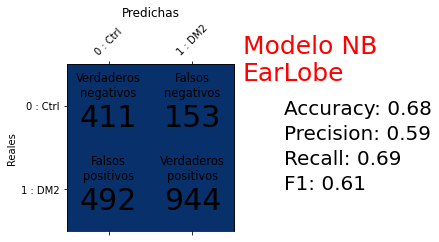

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:27.216892
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:22.312886
------------------------------------------------------------------------


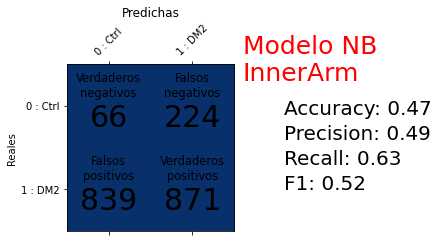

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:22.556147
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:17.028913
------------------------------------------------------------------------


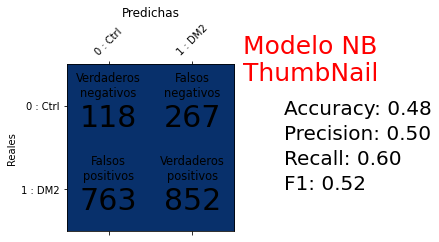

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:17.207952
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:18.870941
------------------------------------------------------------------------


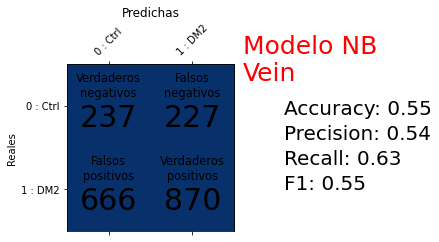

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:19.082736


In [21]:
metrics_nb = {}
for raman_key, raman_value in RamanDF_preprocessed.items():
    start_time_nb = time.time()
    modelNB = GaussianNB(var_smoothing=hyperparameters_nb['best_var_smoothing'])
    metrics_nb[raman_key] = iter_model(raman_value, modelNB, f'Modelo NB\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_nb))}')

In [22]:
start_time_nb = time.time()
hyperparameters_nb_pca = hyperparameters_model_nb(RamanInnerArmDF_preprocessed_pca)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_nb))}')

Tiempo transcurrido (best_hyperparameters): 0:00:02.876297
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:02.792973
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:02.781121
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:02.930519
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:02.864381
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.145783
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.025021
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.063672
-----------------

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:06.194223
------------------------------------------------------------------------


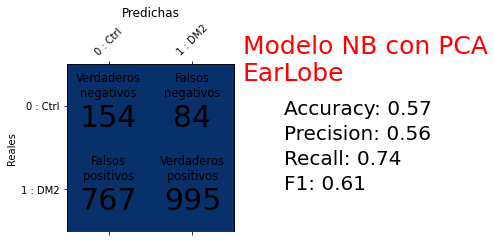

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.432211
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:06.710074
------------------------------------------------------------------------


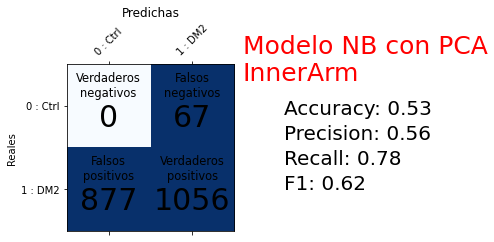

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.909601
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:07.161959
------------------------------------------------------------------------


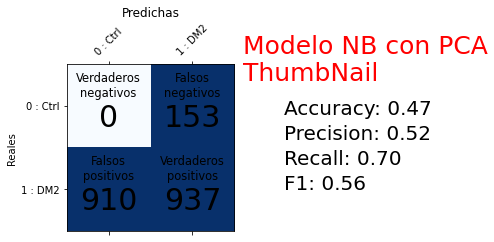

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:07.357934
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:06.591310
------------------------------------------------------------------------


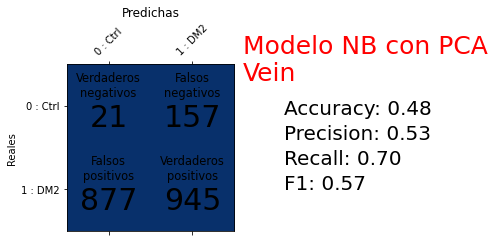

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.754357


In [23]:
metrics_nb_pca = {}
for raman_key, raman_value in RamanDF_preprocessed_pca.items():
    start_time_nb = time.time()
    modelNB_pca = GaussianNB(var_smoothing=hyperparameters_nb_pca['best_var_smoothing'])
    metrics_nb_pca[raman_key] = iter_model(raman_value, modelNB_pca, f'Modelo NB con PCA\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_nb))}')

### K Nearest Neighbor

In [24]:
# Función que busca los hiperparámetros óptimos utilizando, en este caso, RandomizedSearchCV()
def best_hyperparameters_knn(x, y):
    start_time = time.time()

    # Se definen los hiperparámetros de búsqueda
    param_grid_knn = { 'n_neighbors' : [1,3,5,7],
                   'weights' : ['uniform','distance'],
                   'metric' : ['minkowski','euclidean','manhattan']}

    # Se realiza una búsqueda
    grid_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = param_grid_knn,cv = LeaveOneOut(), n_jobs = -1)
    grid_search.fit(x, y)


    best_n_neighbors = grid_search.best_params_['n_neighbors']
    best_weights = grid_search.best_params_['weights']
    best_metric = grid_search.best_params_['metric']
    print(f'Tiempo transcurrido (best_hyperparameters): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_n_neighbors': best_n_neighbors,
            'best_weights': best_weights,
            'best_metric': best_metric}

In [25]:
# Se crea la función que obtiene los mejores hiperparámetros en 10 iteraciones
def hyperparameters_model_knn(raman_df):
    start_time = time.time()
    # Hiperparámetros por iteración
    iter_hyperparameters = []

    for i in range(10):
        iter_hyperparameters.append(best_hyperparameters_knn(raman_df.iloc[:, 1:], raman_df['has_DM2']))

    n_neighbors = []
    weights = []
    metric = []

    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros por iteración')
    for index, hyperparameters_i in enumerate(iter_hyperparameters):
        print('------------------------------------------------------------------------')
        print(f"> Iteración {index + 1} - hiperparámetros: {hyperparameters_i}")
        n_neighbors.append(hyperparameters_i['best_n_neighbors'])
        weights.append(hyperparameters_i['best_weights'])
        metric.append(hyperparameters_i['best_metric'])
    print('------------------------------------------------------------------------')
    print('Mejores hiperparámetros finales')
    print(f'n_neighbors: {mode(n_neighbors)}, weights: {mode(weights)}, metric: {mode(metric)}')
    print(f'Tiempo transcurrido (hyperparameters_model_rna): {timedelta(seconds=(time.time() - start_time))}')
    print('------------------------------------------------------------------------')
    return {'best_n_neighbors': mode(n_neighbors),
            'best_weights': mode(weights),
            'best_metric': mode(metric)}

In [26]:
start_time_knn = time.time()
hyperparameters_knn = hyperparameters_model_knn(RamanInnerArmDF_preprocessed)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_knn))}')

Tiempo transcurrido (best_hyperparameters): 0:00:03.656699
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.116915
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.020172
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:02.955245
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:02.930229
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.066409
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.117431
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:03.279265
-----------------

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:26.908932
------------------------------------------------------------------------


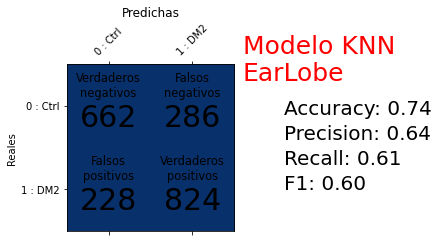

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:27.105847
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:23.245507
------------------------------------------------------------------------


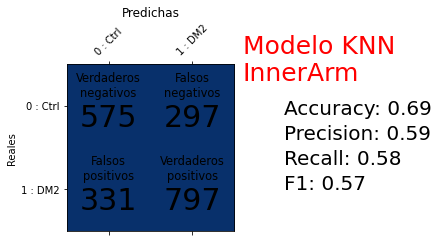

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:23.399731
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:24.799576
------------------------------------------------------------------------


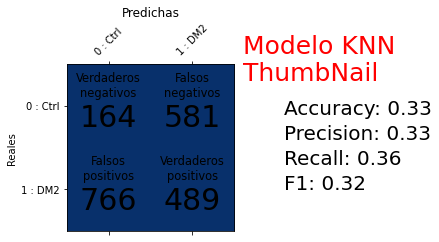

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:24.979105
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:25.789914
------------------------------------------------------------------------


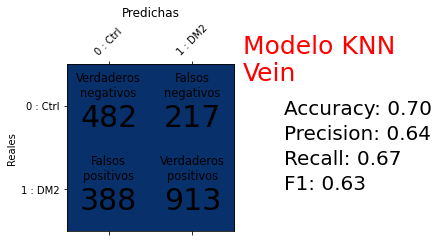

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:25.956792


In [27]:
metrics_knn = {}
for raman_key, raman_value in RamanDF_preprocessed.items():
    start_time_knn = time.time()
    modelKNN = KNeighborsClassifier(metric=hyperparameters_knn['best_metric'], n_neighbors=hyperparameters_knn['best_n_neighbors'], weights=hyperparameters_knn['best_weights'])
    metrics_knn[raman_key] = iter_model(raman_value, modelKNN, f'Modelo KNN\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_knn))}')

In [28]:
start_time_knn = time.time()
hyperparameters_knn_pca = hyperparameters_model_knn(RamanInnerArmDF_preprocessed_pca)
print(f'Tiempo transcurrido búsqueda de hiperparámetros (total): {timedelta(seconds=(time.time() - start_time_knn))}')

Tiempo transcurrido (best_hyperparameters): 0:00:00.817043
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:00.785078
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:00.772510
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:00.795729
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:00.835217
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:00.764936
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:00.819216
------------------------------------------------------------------------
Tiempo transcurrido (best_hyperparameters): 0:00:00.799953
-----------------

------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:06.491031
------------------------------------------------------------------------


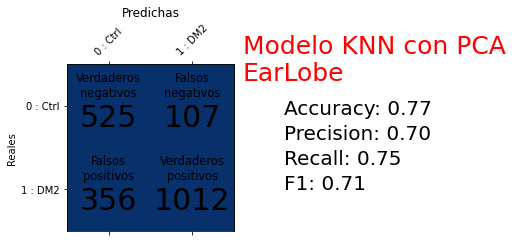

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.650790
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:05.915507
------------------------------------------------------------------------


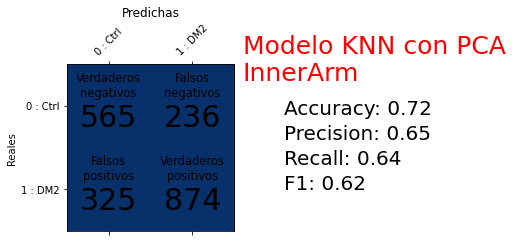

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.101555
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:06.451583
------------------------------------------------------------------------


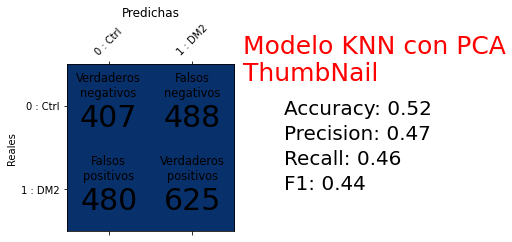

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.616512
------------------------------------------------------------------------
Tiempo transcurrido (iter_model_rna): 0:00:05.999153
------------------------------------------------------------------------


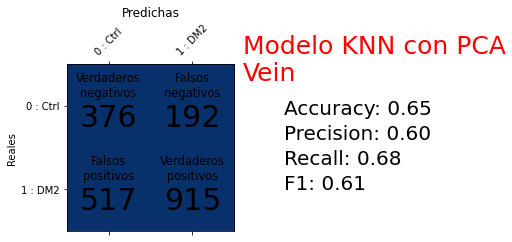

Tiempo transcurrido para las 1000 iteraciones (total): 0:00:06.179281


In [29]:
metrics_knn_pca = {}
for raman_key, raman_value in RamanDF_preprocessed_pca.items():
    start_time_knn = time.time()
    modelKNN_pca = KNeighborsClassifier(metric=hyperparameters_knn_pca['best_metric'], n_neighbors=hyperparameters_knn_pca['best_n_neighbors'], weights=hyperparameters_knn_pca['best_weights'])
    metrics_knn_pca[raman_key] = iter_model(raman_value, modelKNN_pca, f'Modelo KNN con PCA\n{raman_key}')
    print(f'Tiempo transcurrido para las 1000 iteraciones (total): {timedelta(seconds=(time.time() - start_time_knn))}')